In [1]:
from datasets import load_dataset

# Analyzing the content of the columns

In [2]:
ds = load_dataset("Elfsong/Venus", "python3")

In [3]:
ds['train'].features

{'question_id': Value(dtype='int64', id=None),
 'name': Value(dtype='string', id=None),
 'content': Value(dtype='string', id=None),
 'acRate': Value(dtype='float64', id=None),
 'difficulty': Value(dtype='string', id=None),
 'topics': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'runtimeDistribution': Value(dtype='string', id=None),
 'memoryDistribution': Value(dtype='string', id=None),
 'rt_list': [{'code': Value(dtype='string', id=None),
   'runtime': Value(dtype='string', id=None)}],
 'rt_solution_count': Value(dtype='int64', id=None),
 'mm_list': [{'code': Value(dtype='string', id=None),
   'memory': Value(dtype='string', id=None)}],
 'mm_solution_count': Value(dtype='int64', id=None),
 'code_prompt': Value(dtype='string', id=None)}

In [4]:
rt_dist = ds['train'][0]['runtimeDistribution']

In [5]:
import json

In [6]:
rt_dist = json.loads(rt_dist)

In [7]:
import matplotlib.pyplot as plt


In [8]:
def plot_distribution(data, name=None, instance=None):
    x = [int(item[0]) for item in data]
    y = [item[1] for item in data]

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='o', linestyle='-', color='b', label="Distribution")
    
    # If an instance tuple is provided, plot it with a different color
    if instance is not None:
        # Assuming the instance tuple is (runtime, frequency)
        instance_runtime = (instance[0])
        instance_freq = instance[1]
        plt.plot(instance_runtime, instance_freq, marker='o', markersize=10, 
                 linestyle='None', color='r', label="Instance")
    
    plt.xlabel(name)
    plt.ylabel("Frequency")
    plt.title(f"{name} Distribution")
    plt.grid(True)
    plt.legend()
    plt.show()

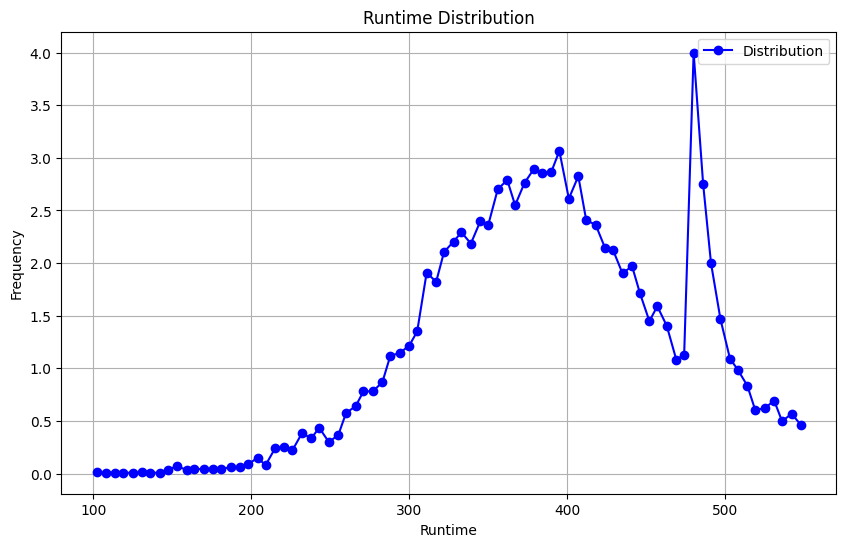

In [9]:
plot_distribution(rt_dist['distribution'], name='Runtime')

In [10]:
import pandas as pd

In [11]:

def to_pandas_df(data, name):
    dist_df = pd.DataFrame(data, columns=[name, 'frequency'])

    # Convert the 'Runtime' column from string to integer
    dist_df[name] = dist_df[name].astype(int)

    # Sort the DataFrame by runtime
    dist_df.sort_values(name, inplace=True)

    # Compute the cumulative sum of frequencies
    # dist_df['Cumulative'] = dist_df['frequency'].cumsum()

    return dist_df

In [12]:
dist_df = to_pandas_df(rt_dist['distribution'], 'runtime')

In [13]:
# Picking a random sample to see where it fit on the distribution
row = dist_df.sample(n=1)
row

,runtime,frequency
57,424,2.1415


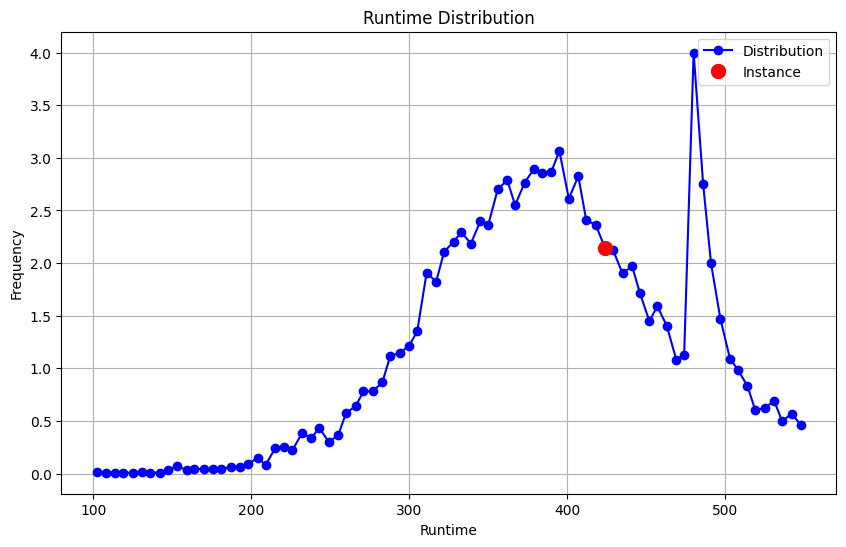

In [14]:
point = (int(row['runtime'].iloc[0]), row['frequency'])
plot_distribution(rt_dist['distribution'], 'Runtime', point)

In [15]:
import numpy as np

In [16]:
# get the nth percentile value of the distribution
def get_nth_percentile(distribution_df, percentile, metric):
    data = np.array(distribution_df[metric])
    return np.percentile(data, percentile)

# check if an instance of the distribution falls into the nth percentile
def is_within_nth_percentile(nth_percentile, instance):
    return instance <= nth_percentile

In [17]:
get_nth_percentile(dist_df, 25, 'runtime')

213.5

# Constructing the dataset

In [18]:
json_dataset = []

# Iterate over the 'train' split
for row in ds["train"]:
    # Runtime solutions
    runtime_efficient_codes = []
    runtime_inefficient_codes = []
    runtime_moderate_codes = []

    # Memory solutions
    memory_efficient_codes = []
    memory_inefficient_codes = []
    memory_moderate_codes = []

    # Get both runtime and memory distribution for the current problem
    runtime_distribution = to_pandas_df(json.loads(row['runtimeDistribution'])['distribution'], 'runtime')
    memory_distribution = to_pandas_df(json.loads(row['memoryDistribution'])['distribution'], 'memory')

    # Obtain the 25th and 75th percentile 
    runtime_twenty_fifth_percentile = get_nth_percentile(runtime_distribution, 25, 'runtime')
    runtime_seventy_fifth_percentile = get_nth_percentile(runtime_distribution, 75, 'runtime')

    for rt_item in row['rt_list']:
        # runtime of the current solution
        runtime = int(rt_item['runtime'])

        if runtime <= runtime_twenty_fifth_percentile:
            runtime_efficient_codes.append(rt_item)
        elif runtime >= runtime_seventy_fifth_percentile:
            runtime_inefficient_codes.append(rt_item)
        else:
            runtime_moderate_codes.append(rt_item)


    # Obtain the 75th percentile for both runtime and memory distribution
    memory_twenty_fifth_percentile = get_nth_percentile(memory_distribution, 25, 'memory')
    memory_seventy_fifth_percentile = get_nth_percentile(memory_distribution, 75, 'memory')

    # Applying the same concept as the above, but for memory efficent code
    for mm_item in row['mm_list']:
        # memory of the current solution
        memory = int(mm_item['memory'])

        if memory <= memory_twenty_fifth_percentile:
            memory_efficient_codes.append(mm_item)
        elif memory >= memory_seventy_fifth_percentile:
            memory_inefficient_codes.append(mm_item)
        else:
            memory_moderate_codes.append(mm_item)

    json_data = {
        'question_id': row['question_id'],
        'name': row['name'],
        'prompt': row['content'],
        'difficulty': row['difficulty'],
        'topics': row['topics'],
        'runtime_inefficient_codes': runtime_inefficient_codes,
        'runtime_moderate_codes': runtime_moderate_codes,
        'runtime_efficient_codes': runtime_efficient_codes,
        'memory_inefficient_codes': memory_inefficient_codes,
        'memory_moderate_codes': memory_moderate_codes,
        'memory_efficient_codes': memory_efficient_codes,
    }

    json_dataset.append(json_data)


In [19]:
with open('dataset.json', 'w') as json_file:
    json.dump(json_dataset, json_file, indent=4)

In [20]:
pd.DataFrame(json_dataset).head()

,question_id,name,prompt,difficulty,topics,runtime_inefficient_codes,runtime_moderate_codes,runtime_efficient_codes,memory_inefficient_codes,memory_moderate_codes,memory_efficient_codes
0,131,palindrome-partitioning,"<p>Given a string <code>s</code>, partition <c...",Medium,"[string, dynamic-programming, backtracking]",[{'code': 'class Solution: def partition(s...,[{'code': 'class Solution: def partition(s...,[{'code': '# class Solution: def partition( s:...,[{'code': 'class Solution: def partition(s...,[{'code': 'class Solution: def partition(s...,[{'code': 'from collections.abc import Generat...
1,132,palindrome-partitioning-ii,"<p>Given a string <code>s</code>, partition <c...",Hard,"[string, dynamic-programming]",[{'code': 'class Solution: def minCut(self...,[{'code': 'class Solution: def minCut(self...,[{'code': 'class Solution: def minCut(self...,[{'code': 'class Solution: def minCut(self...,[{'code': 'class Solution: def minCut(self...,[{'code': 'class Solution: def minCut(self...
2,133,clone-graph,<p>Given a reference of a node in a <strong><a...,Medium,"[hash-table, depth-first-search, breadth-first...","[{'code': '"""""" # Definition for a Node. class ...","[{'code': '"""""" # Definition for a Node. class ...",[{'code': 'class Solution: def cloneGraph(...,"[{'code': '"""""" # Definition for a Node. class ...","[{'code': '"""""" # Definition for a Node. class ...","[{'code': '"""""" # Definition for a Node. class ..."
3,134,gas-station,<p>There are <code>n</code> gas stations along...,Medium,"[array, greedy]",[{'code': 'class Solution: def canComplete...,[{'code': 'class Solution: def canComplete...,[{'code': 'def canCompleteCircuit(gas: List[in...,[{'code': 'class Solution: def canComplete...,[{'code': 'class Solution: def canComplete...,[{'code': 'class Solution: def canComplete...
4,135,candy,<p>There are <code>n</code> children standing ...,Hard,"[array, greedy]","[{'code': 'class Solution: def candy(self,...","[{'code': 'class Solution: def candy(self,...",[{'code': 'class Solution: def candy(self...,"[{'code': 'class Solution: def candy(self,...","[{'code': 'class Solution: def candy(self,...","[{'code': 'class Solution: def candy(self,..."
